In [1]:
import sys, os

folder_path = '../models/'
if folder_path not in sys.path:
    sys.path.append(folder_path)

from cnmp import CNMP
from cnep import CNEP

import numpy as np
import torch
from movement_primitives.promp import ProMP
from movement_primitives.dmp import DMP
from gmr import GMM
import matplotlib.pyplot as plt

In [2]:
root_path = '/home/yigit/projects/cnep/outputs/'
test_path = 'sine/4_sine/cnmp_cnep/1715619443'

data_path = root_path + test_path + '/y.pt'

Y = torch.load(data_path, map_location='cpu').to('cpu').numpy().squeeze(-1)
x = np.linspace(0, 1, Y.shape[1])
print(f'x: {x.shape}, Y: {Y.shape}')


Y_means = np.zeros((4,Y.shape[1]))
for i in range(4):
    Y_means[i] = np.mean(Y[i*32:(i+1)*32], axis=0)

x: (200,), Y: (128, 200)


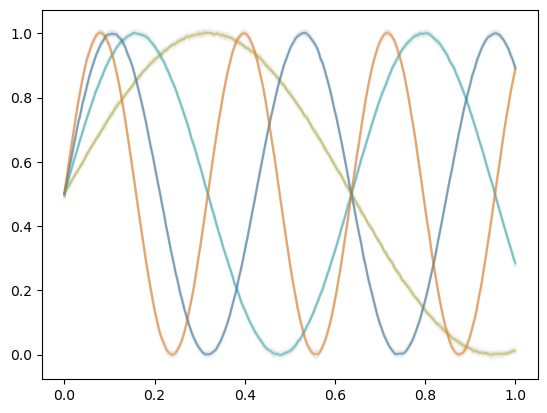

In [9]:
# plot Y and Y_means
plt.plot(x, Y.T, label='Y', alpha=0.01)
plt.plot(x, Y_means.T, label='Y_means', alpha=0.5)
plt.show()

In [4]:
def find_closest_traj_ind(traj):
    # find the closest trajectory in the dataset
    min_dist = np.inf
    min_ind = -1
    for i, y in enumerate(Y_means):
        dist = np.linalg.norm(y - traj)  # euclidean distance between two trajectories
        if dist < min_dist:
            min_dist = dist
            min_ind = i
    return min_ind


def compute_rmse(traj0, traj1):
    # compute the RMSE between two trajectories
    return np.sqrt(np.mean((traj0 - traj1) ** 2))


def compute_mae(traj0, traj1):
    # compute the MAE between two trajectories
    return np.mean(np.abs(traj0 - traj1))


def compute_max_error(traj0, traj1):
    # compute the maximum error between two trajectories
    return np.max(np.abs(traj0 - traj1))

In [5]:
d = DMP(n_dims=1, n_weights_per_dim=4, dt=1/(Y.shape[1]-1))  # -1 so that it uses Y.shape[1] points

for i, traj in enumerate(Y):
    d.imitate(x, traj.reshape(-1,1))

p = ProMP(n_dims=1, n_weights_per_dim=4)
p.imitate(np.tile(x, (Y.shape[0], 1)), Y)

input_data = x.reshape(-1, 1)  # Phase variable as a column vector

priors = 4  # Number of GMM components
gmr_model = GMM(n_components=priors, random_state=1234)
gmr_model.from_samples(Y)

In [6]:
root_path = "/home/yigit/projects/cnep/outputs/sine/4_sine/cnmp_cnep/"
run_id, model_folder = '1715613941', '/saved_models/'
models_path = f'{root_path}{run_id}{model_folder}'

cnmp_path, cnep_path = f'{models_path}cnmp.pt', f'{models_path}cnep.pt'

batch_size = 1
dx, dy = 1, 1
n_max, m_max = 10, 10
t_steps = 200
device = 'cpu'
cnmp = CNMP(dx, dy, n_max, m_max, [104,104], decoder_hidden_dims=[104,104], batch_size=batch_size, device=device)
cnep = CNEP(dx, dy, n_max, m_max, [64,64], num_decoders=4, decoder_hidden_dims=[64, 64], batch_size=batch_size, scale_coefs=True, device=device)

cnmp.load_state_dict(torch.load(cnmp_path, map_location='cpu'))
cnep.load_state_dict(torch.load(cnep_path, map_location='cpu'))


# data for testing cnxp
val_obs = torch.zeros((batch_size, n_max, dx+dy), dtype=torch.float32, device=device)
val_tar_x = torch.zeros((batch_size, t_steps, dx), dtype=torch.float32, device=device)
# val_tar_y = torch.zeros((batch_size, t_steps, dy), dtype=torch.float32, device=device)
val_obs_mask = torch.zeros((batch_size, n_max), dtype=torch.bool, device=device)

val_obs.fill_(0)
val_tar_x.fill_(0)
val_obs_mask.fill_(False)

val_obs_mask[0, :2] = True

val_tar_x[0] = torch.linspace(0, 1, t_steps).unsqueeze(1)
val_obs[0, :2, :dx] = torch.tensor([0, 1]).unsqueeze(1)

In [7]:
num_tests = 100

y0 = np.mean(Y[:, 0])
y1_min, y1_max = np.min(Y[:, -1]), np.max(Y[:, -1])

y1s = np.linspace(y1_min, y1_max, num_tests)

rmse_errors = np.zeros((num_tests, 5))  # 5 models
mae_errors = np.zeros((num_tests, 5))
max_errors = np.zeros((num_tests, 5))


for i in range(num_tests):
    y1 = y1s[i]

    # DMP
    d.configure(start_y=[y0], goal_y=[y1])
    t, trajectory = d.open_loop()

    # ProMP
    p = p.condition_position(y0, t=0).condition_position(y1, t=1)
    trajectory_p = p.sample_trajectories(x, 1, np.random.RandomState(seed=1234))

    # GMR
    gmr_model_ = gmr_model.condition([0, -1], [y0, y1])
    trajectory_g = gmr_model_.sample(1)
    trajectory_g = np.insert(trajectory_g, 0, y0)
    trajectory_g = np.append(trajectory_g, y1)

    # CNMP and CNEP
    val_obs[0, :2, dx:] = torch.tensor([y0, y1]).unsqueeze(1)

    with torch.no_grad():
        trajectory_cnmp = cnmp.val(val_obs, val_tar_x, val_obs_mask)[:, :, :dy]
        pred_cnep, gate = cnep.val(val_obs, val_tar_x, val_obs_mask)
        dec_id = torch.argmax(gate.squeeze(1), dim=-1)
        trajectory_cnep = pred_cnep[dec_id, 0, :, :dy]

    for j in range(5):
        if j == 0:
            traj = trajectory
        elif j == 1:
            traj = trajectory_p.squeeze(0)
        elif j == 2:
            traj = trajectory_g
        elif j == 3:
            traj = trajectory_cnmp.squeeze(0).squeeze(-1).numpy()
        else:
            traj = trajectory_cnep.squeeze(0).squeeze(-1).numpy()

        closest_traj_ind = find_closest_traj_ind(traj)

        rmse_errors[i, j] = compute_rmse(traj, Y_means[closest_traj_ind])
        mae_errors[i, j] = compute_mae(traj, Y_means[closest_traj_ind])
        max_errors[i, j] = compute_max_error(traj, Y_means[closest_traj_ind])

In [11]:
# print mean errors and standard deviations
print('RMSE')
print(np.mean(rmse_errors, axis=0))
print(np.std(rmse_errors, axis=0))
print('MAE')
print(np.mean(mae_errors, axis=0))
print(np.std(mae_errors, axis=0))
print('Max error')
print(np.mean(max_errors, axis=0))
print(np.std(max_errors, axis=0))

RMSE
[0.63854757 0.42116607 0.12254685 0.24891604 0.01383524]
[0.16279148 0.03027526 0.08081901 0.10346136 0.00567555]
MAE
[0.53790006 0.3454031  0.09576623 0.21512907 0.0104613 ]
[0.14748168 0.02509646 0.06311913 0.0898836  0.00391041]
Max error
[1.37474253 1.03734123 0.24228625 0.42680727 0.04174447]
[0.26337987 0.05086212 0.15213736 0.18046386 0.02354905]


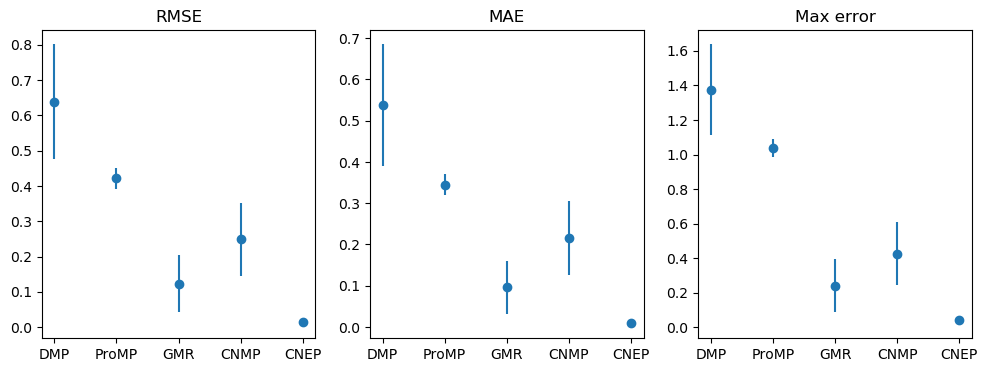

In [13]:
# plot mean errors and standard deviations 
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
x_labels = ['DMP', 'ProMP', 'GMR', 'CNMP', 'CNEP']
ax[0].errorbar(x_labels, np.mean(rmse_errors, axis=0), np.std(rmse_errors, axis=0), fmt='o')
ax[0].set_title('RMSE')
ax[1].errorbar(x_labels, np.mean(mae_errors, axis=0), np.std(mae_errors, axis=0), fmt='o')
ax[1].set_title('MAE')
ax[2].errorbar(x_labels, np.mean(max_errors, axis=0), np.std(max_errors, axis=0), fmt='o')
ax[2].set_title('Max error')
plt.show()

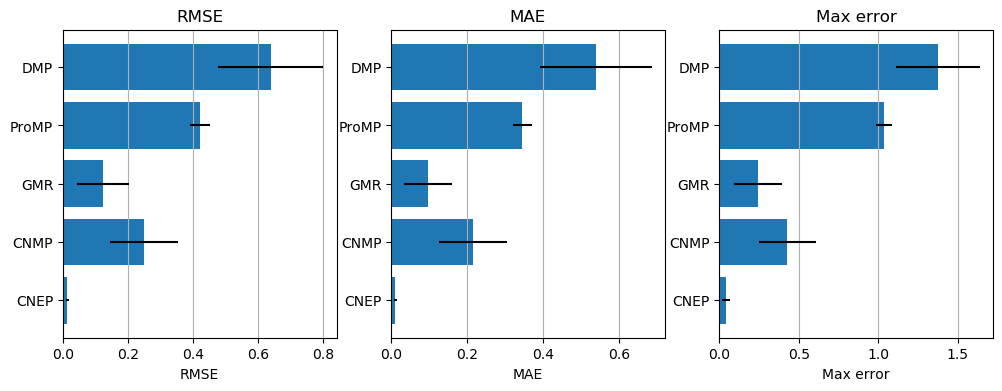

In [17]:
# plot mean errors and standard deviations as horizontal bars
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
y_pos = np.arange(len(x_labels))
ax[0].barh(y_pos, np.mean(rmse_errors, axis=0), xerr=np.std(rmse_errors, axis=0), align='center')
ax[0].set_yticks(y_pos)
ax[0].set_yticklabels(x_labels)
ax[0].invert_yaxis()
ax[0].set_xlabel('RMSE')
ax[0].set_title('RMSE')
ax[1].barh(y_pos, np.mean(mae_errors, axis=0), xerr=np.std(mae_errors, axis=0), align='center')
ax[1].set_yticks(y_pos)
ax[1].set_yticklabels(x_labels)
ax[1].invert_yaxis()
ax[1].set_xlabel('MAE')
ax[1].set_title('MAE')
ax[2].barh(y_pos, np.mean(max_errors, axis=0), xerr=np.std(max_errors, axis=0), align='center')
ax[2].set_yticks(y_pos)
ax[2].set_yticklabels(x_labels)
ax[2].invert_yaxis()
ax[2].set_xlabel('Max error')
ax[2].set_title('Max error')

ax[0].grid(axis='x')
ax[1].grid(axis='x')
ax[2].grid(axis='x')
plt.show()